#  XPCS   GiSAXS Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
%matplotlib notebook
#%matplotlib inline+

In [2]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

/XF11ID/analysis/Analysis_Pipelines/Develop


In [3]:
%run XPCS_GiSAXS.py

/opt/conda_envs/analysis/lib/python3.4/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


# Startup Setting

## Detector

In [4]:
detector = 'eiger4m_single_image'
detector = 'eiger_4M_cam_img_image_lightfield'  #for 4M

In [5]:
path = '/XF11ID/analysis/2016_1/yuzhang/Results/'


print ("The analysis results will be saved in : %s"%path)
dt =datetime.now()
CurTime = '%s%02d%02d-%02d%02d-' % (dt.year, dt.month, dt.day,dt.hour,dt.minute)


#mask_name =  "March_colloidal"  +"_mask.npy"  #good for AuRod
#mask_name = 'corapor331'+"_mask.npy"
mask_name = 'mask_0406.npy'
#mask_name =  "March28_colloidal"  +"_mask.npy"

The analysis results will be saved in : /XF11ID/analysis/2016_1/yuzhang/Results/


In [7]:
#db(  sequence_ID = 96  )

### Get the image series and metadata from the uid

In [6]:
uid = 'de26b5da-bb3a-4e0a-98fd-41df25f869d4'
uid = 'ffe9d518'  # 10 mTorr 1sec/frame

In [7]:
get_sid_filenames(db[uid])

(671,
 'ffe9d518-aa6a-43d7-8eb0-17e285796e7b',
 ['/XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5'])

In [27]:
#detectors = ['eiger4m_single_image', 'eiger1m_single_image', 'eiger4m_image', 'eiger1m_image']

In [28]:
imgs = load_data( uid, detector  )
md = imgs.md

hdf5 path = /XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5_master.h5


In [29]:
imgs

<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32

## Overwrite some metadata due to wrong input

In [30]:
md

{'beam_center_x': 840.0,
 'beam_center_y': 1830.0,
 'count_time': 1.0,
 'detector_distance': 4.8400002,
 'frame_time': 1.00001,
 'framerate': 0.99998998651994853,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [31]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.81        # detector to sample distance (mm)

exposuretime= md['count_time']
acquisition_period = md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

In [32]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, )

In [33]:
setup_pargs

{'Ldet': 4.81,
 'dpix': 0.075000003562308848,
 'lambda_': 1.3776,
 'timeperframe': 1.00001,
 'uid': 'ffe9d518'}

In [17]:
imgs.shape

(2167, 2070)

## load a mask if exist 
### otherwise create a mask using Mask pipeline

<IPython.core.display.Javascript object>


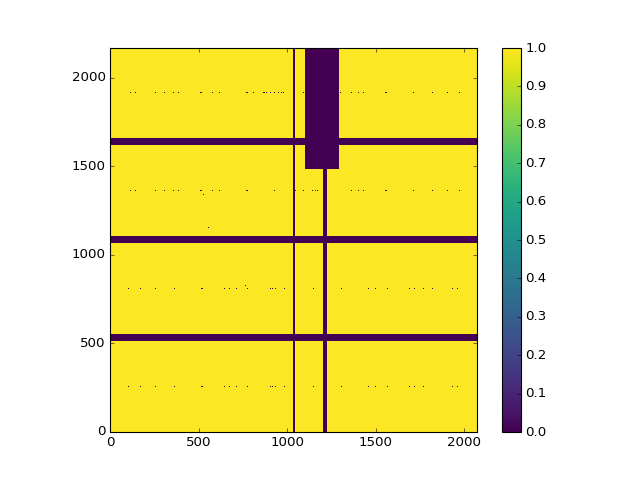

In [18]:
mask = load_mask( path, mask_name, plot_ =  True )

## Apply Mask to time-series
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software

In [19]:
maskr = mask[::-1,:]

<IPython.core.display.Javascript object>


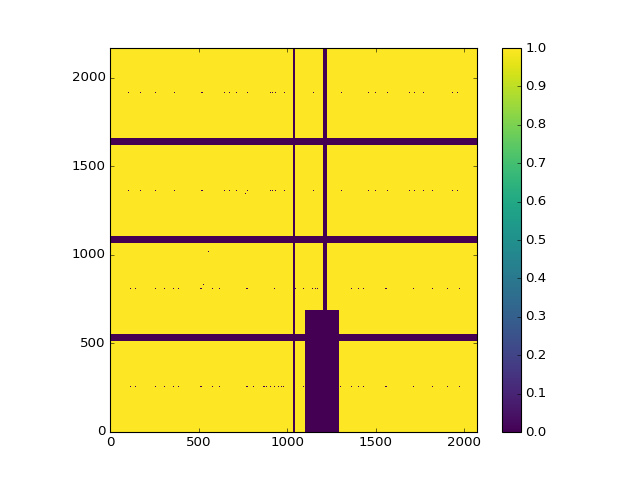

In [20]:
show_img( maskr)

In [21]:
imgsr = reverse_updown( imgs )

In [22]:
imgsra = apply_mask( imgsr, maskr )

<IPython.core.display.Javascript object>


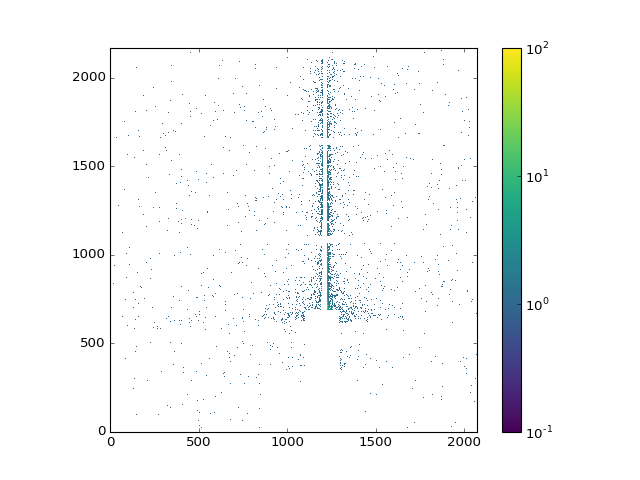

In [23]:
show_img( imgsra[0],  norm= LogNorm(vmin=0.1, vmax=100)) 

## Check shutter open frame and get good time series

In [24]:
good_start = check_shutter_open( imgsra,  min_inten=5, time_edge = [0,10], plot_ = False )

The first frame with open shutter is : 0


In [25]:
good_series = apply_mask( imgsr[good_start:], maskr )

## Find bad frames by checking total scattering intensity 

<IPython.core.display.Javascript object>


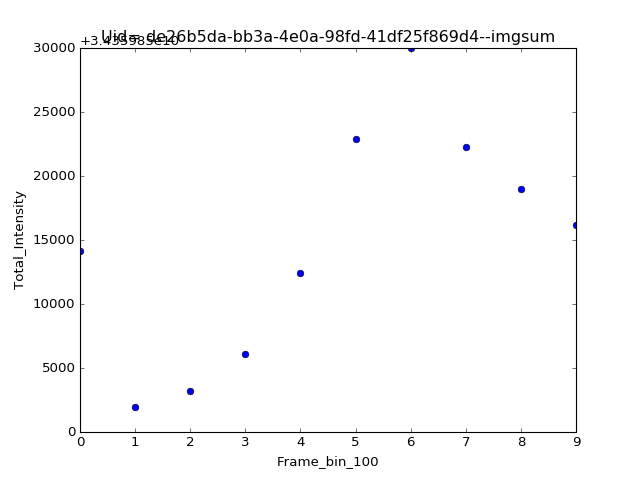

No bad frames are involved.


In [26]:
imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = 100, 
                                bad_pixel_threshold=1e14,  plot_ = True, uid=uid)

## Get intensity average image

<IPython.core.display.Javascript object>


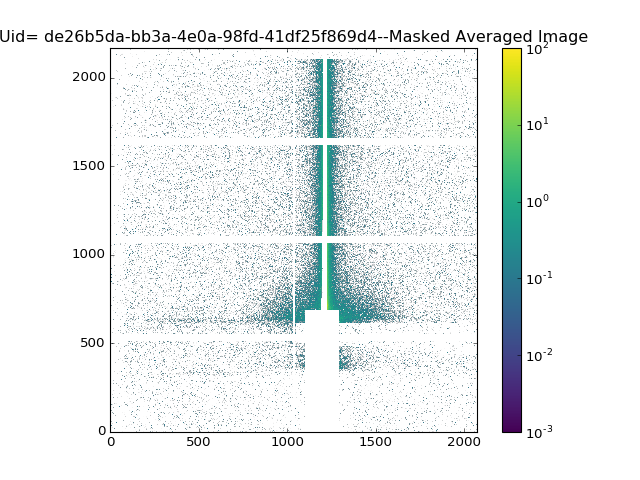

In [27]:
avg_imgr =  get_avg_img( good_series, sampling = 100, plot_ = True, uid =uid)

## GiSAXS get q-map (qz and qr)
* Users put incident-Beam and Reflection_Beam Centers here!!!

In [28]:
inc_x0 = 1210   #1210  #in pixel
inc_y0 =   316 # 327


refl_x0 =   1210  #1210
refl_y0 =    618  #620     #1670

Lsd= 4.81
lamda= lambda_  #12.4/9

In [29]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Lsd )
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lamda, Lsd=Lsd )

The incident_angle (alphai) is: 0.13490018856
The incident_angle (alphai) is: 0.13490018856


<IPython.core.display.Javascript object>


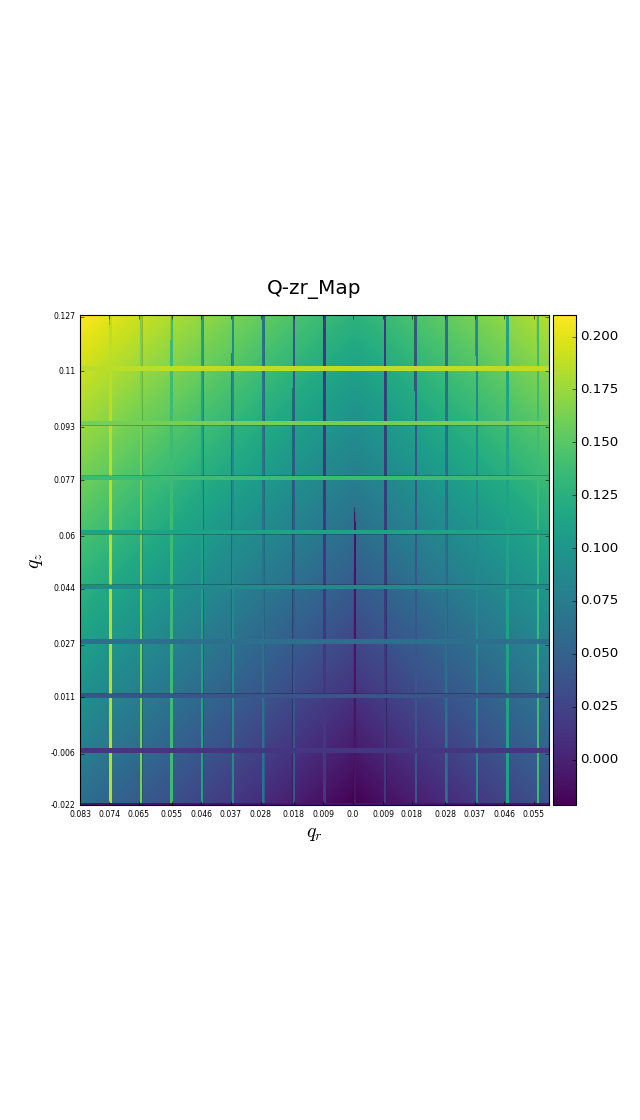

In [61]:
ticks = show_qzr_map(  qr, qz, inc_x0, data = None, Nzline=10, Nrline= 10   )

<IPython.core.display.Javascript object>


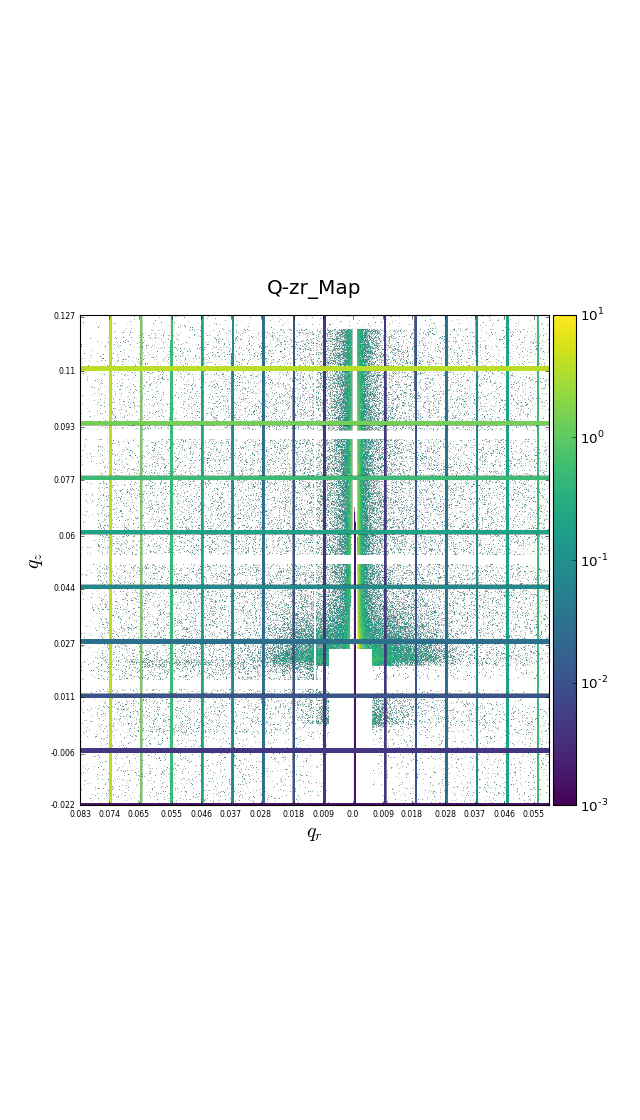

In [60]:
ticks = show_qzr_map(  qr,qz, inc_x0, data = avg_imgr, Nzline=10,  Nrline=10   )

## Get q||-intensity¶
* Users put cuts here for static analysis

In [32]:
## to make two-qz, from 0.018 to 0.046, width as 0.008, 
qz_width = 0.002
qz_num= 3

qz_start = 0.02 + qz_width/qz_num
qz_end = 0.04  -  qz_width/qz_num
 

#to make one-qr, from 0.02 to 0.1, and the width is 0.1-0.012
qr_width =  0.06
qr_start =    0.001 + qr_width  /2
qr_end =  0.06 -  qr_width  /2
qr_num = 1
 
Qr = [qr_start , qr_end, qr_width, qr_num]
Qz=  [qz_start,   qz_end,  qz_width , qz_num ]

In [33]:
new_mask = np.ones_like(avg_imgr, dtype= np.int)
new_mask[ :, 1020:1045] =0

The qr_edge is:  [ 0.001  0.061]
The qr_center is:  [ 0.031]
The qz_edge is:  [ 0.01966667  0.02166667  0.029       0.031       0.03833333  0.04033333]
The qz_center is:  [ 0.02066667  0.03        0.03933333]


<IPython.core.display.Javascript object>


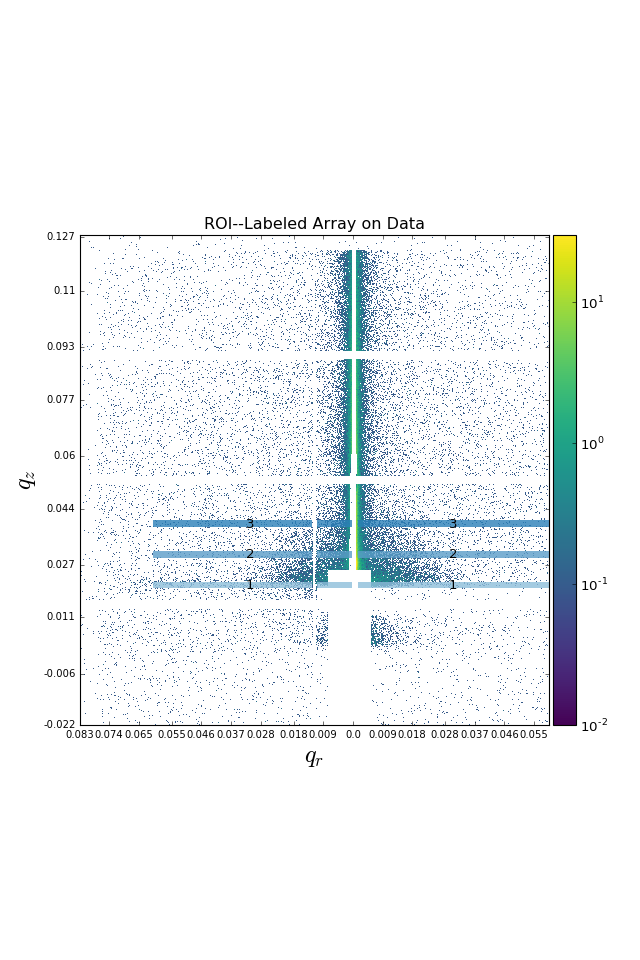

<IPython.core.display.Javascript object>


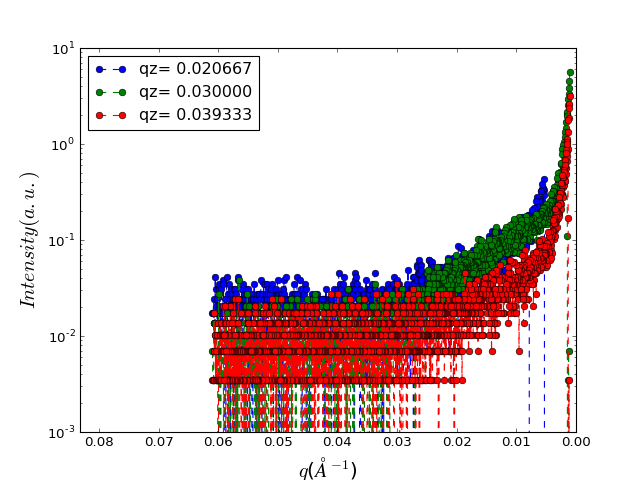

In [62]:
qr_1d = get_1d_qr( avg_imgr, Qr, Qz, qr, qz, inc_x0,  new_mask,  True, ticks, .8)

## User provide the interested Qz and Qr here for XPCS analysis

In [35]:
qz_start = 0.030
qz_end = 0.044
qz_num = 2
qz_width =(qz_end - qz_start)/(qz_num)
#print('qz_width: ',  qz_width)

    

qr_start =  0.003
qr_end = 0.01
qr_num = 10
qr_width = (qr_end - qr_start)/( qr_num)


## Create label array (Qz, Qr, Qzr boxes)

In [36]:
qr_edge, qr_center = get_qedge(qr_start, qr_end, qr_width, qr_num )
qz_edge, qz_center = get_qedge(qz_start, qz_end, qz_width, qz_num )
      
label_array_qz = get_qmap_label(qz, qz_edge)
label_array_qr = get_qmap_label(qr, qr_edge)

label_array_qzr, qzc, qrc = get_qzrmap(label_array_qz, label_array_qr, 
                                       qz_center, qr_center)

labels_qzr, indices_qzr = roi.extract_label_indices(label_array_qzr)
labels_qz, indices_qz = roi.extract_label_indices(label_array_qz)
labels_qr, indices_qr = roi.extract_label_indices(label_array_qr)

num_qz = len(np.unique(labels_qz))
num_qr = len(np.unique(labels_qr))
num_qzr = len(np.unique(labels_qzr))

## Extract the labeled array

In [37]:
boxes = label_array_qzr 
box_maskr = boxes*maskr

qind, pixelist = roi.extract_label_indices(box_maskr)
noqs = len(np.unique(qind))

## Number of pixels in each q box

In [38]:
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([2040, 2244, 2040, 2040, 2040, 2040, 2040, 2040, 2040, 2040, 2020,
       2222, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020])

## plot average image with interested Q-regions (boxes)

<IPython.core.display.Javascript object>


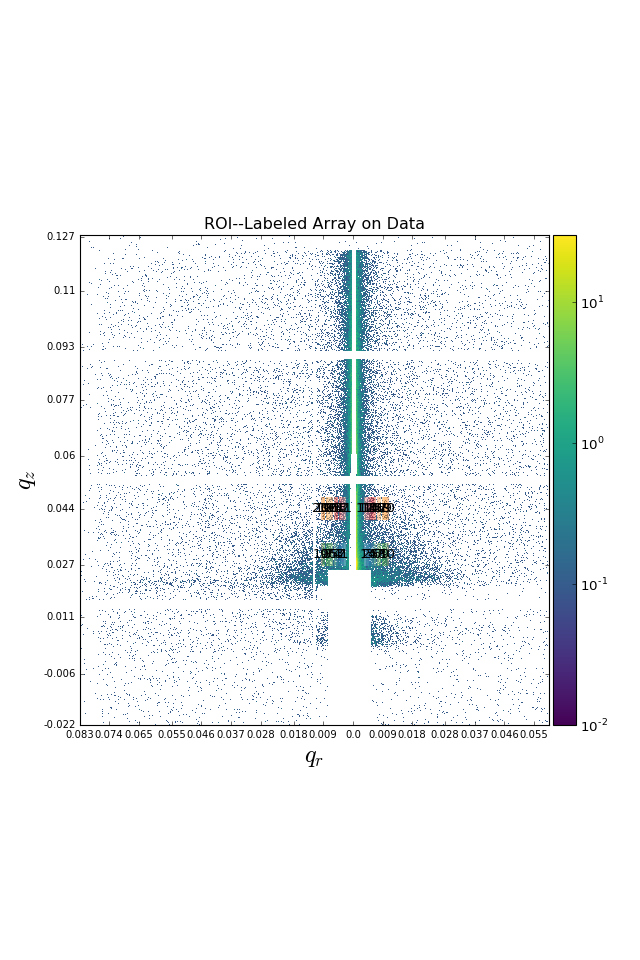

In [63]:
show_qzr_roi( avg_imgr, box_maskr, inc_x0, ticks, alpha=0.5   )

## Check one box intensity 

<IPython.core.display.Javascript object>


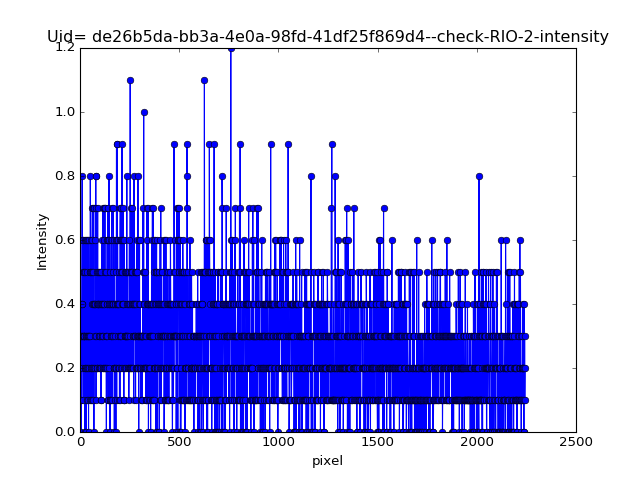

In [40]:
roi_inten = check_ROI_intensity( avg_imgr, box_maskr, ring_number= 2, uid =uid )

In [41]:
#h1, b1 = np.histogram( roi_inten, bins = 100 )
#plot1D( h1 )

## Check beam damage
* check mean intensity of each box as a function of time

<IPython.core.display.Javascript object>


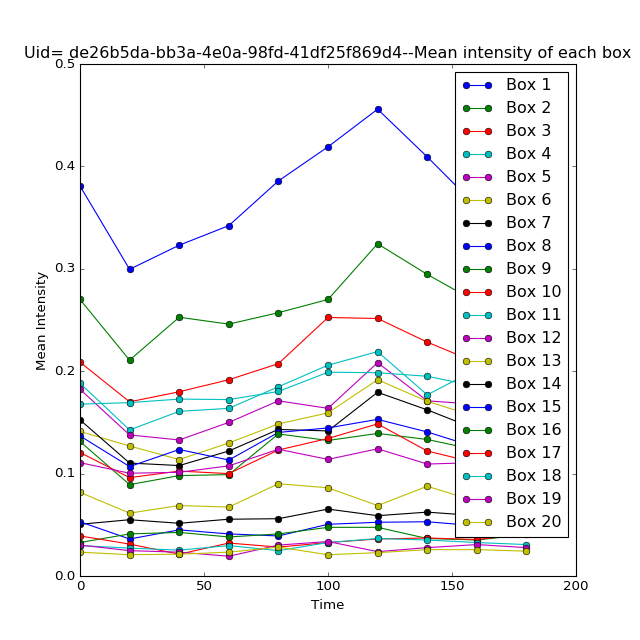

In [42]:
mean_int_sets = get_each_box_mean_intensity( good_series, box_maskr, sampling = 100,
                                timeperframe = md['frame_time'], plot_ = True, uid=uid  )

In [43]:
%run XPCS_GiSAXS.py

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

In [44]:
bad_image_process = False
if  len(bad_frame_list):
    bad_image_process = True
bad_image_process 

False

### if define another good_series

In [45]:
#good_start = 10
#good_end = 300 #len( imgs )
#good_series = apply_mask( imgsr[good_start:good_end-1], maskr )

In [46]:
t0 = time.time()
g2, lag_steps  =cal_g2( good_series,  box_maskr, bad_image_process,
                       bad_frame_list,good_start, num_buf = 8 )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--9--
1000 frames will be processed...
G2 calculation DONE!
Total time: 0.91 min


In [47]:
taus = lag_steps * timeperframe

res_pargs = dict(taus=taus, qz_center=qz_center, qr_center=qr_center,
                 path=path, uid=uid        )

In [48]:
save_gisaxs_g2(  g2,res_pargs )

The g2 of uid= de26b5da-bb3a-4e0a-98fd-41df25f869d4 is saved in /XF11ID/analysis/2016_1/yuzhang/Results/ with filename as g2-de26b5da-bb3a-4e0a-98fd-41df25f869d4-20160414-1834-.csv


### Plot the one time correlation functions

In [49]:
#%matplotlib inline

<IPython.core.display.Javascript object>


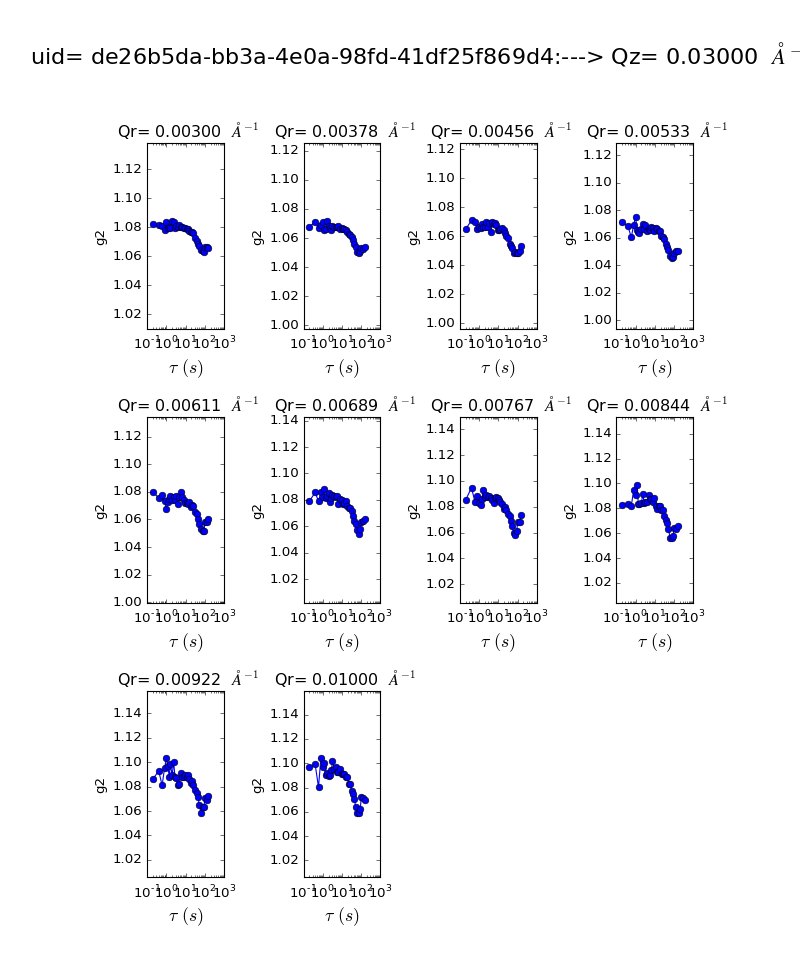

<IPython.core.display.Javascript object>


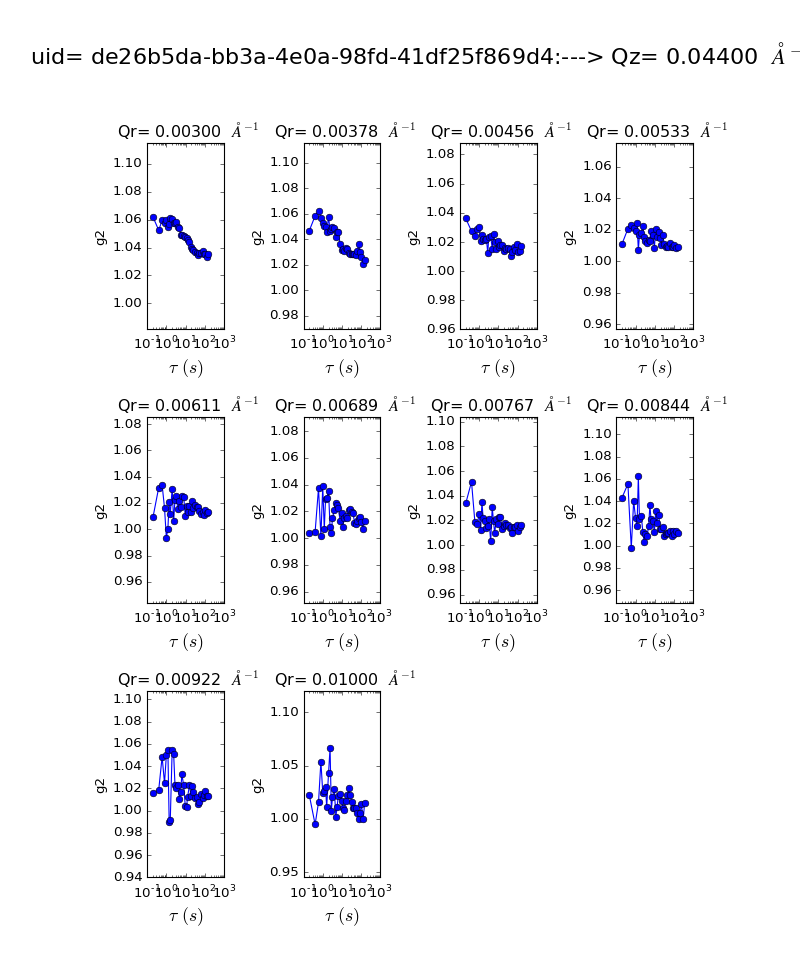

In [50]:
plot_gisaxs_g2( g2, taus,  vlim=[0.95, 1.05], res_pargs=res_pargs)              
#plot_gisaxs_g2( g2, taus,  vlim=[0.95, 1.05],qz_center=qz_center, qr_center=qr_center,uid = uid, path=path )

# Fit g2

In [51]:
fit= True

<IPython.core.display.Javascript object>


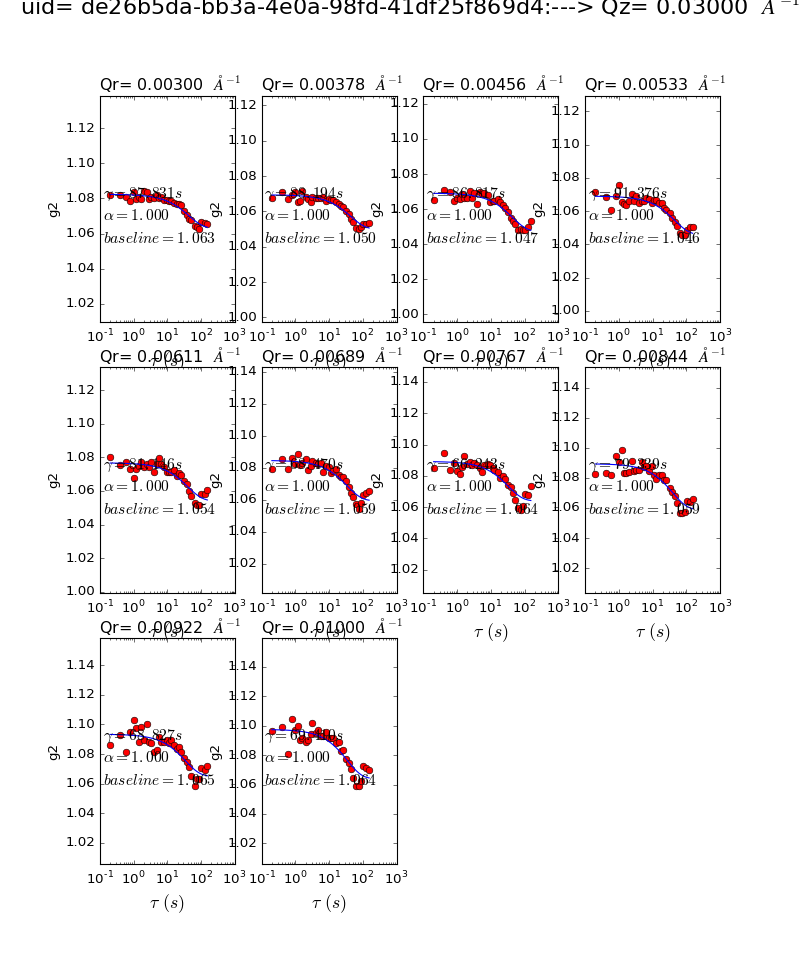

<IPython.core.display.Javascript object>


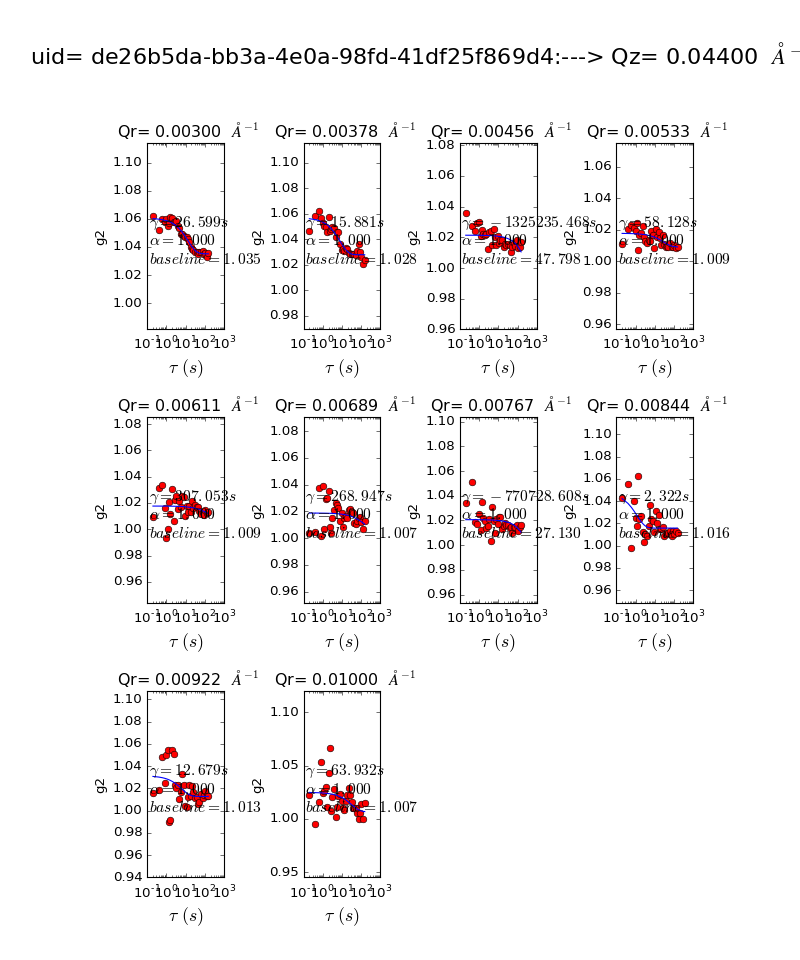

In [52]:
if fit:
    result = fit_gisaxs_g2( g2, res_pargs, function = 'simple',  vlim=[0.95, 1.05],)

In [53]:
#result

# For two-time

In [54]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

/XF11ID/analysis/Analysis_Pipelines/Develop


In [55]:
run_two_time = True #False

In [56]:
if run_two_time:

    %run Two_Time_Correlation_Function.py
    qind, pixelist = roi.extract_label_indices(   box_maskr  )
    #good_start = 10
    #good_end = 300 #len( imgs )
    #good_series = apply_mask( imgsr[good_start:good_end-1], maskr )

    t0 = time.time()
    data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()
    run_time(t0)
    g12b = auto_two_Array( good_series, box_maskr, data_pixel = data_pixel ) 

Total time: 0.86 min
###########Total time: 0.03 min


<IPython.core.display.Javascript object>


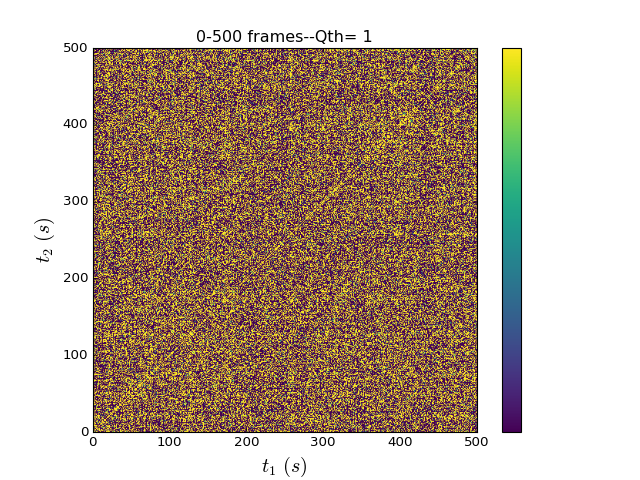

In [57]:
if run_two_time:
    show_C12(g12b, q_ind=1, N1=0, N2=500, vmin=1.06, vmax=1.08,  )

In [58]:
if run_two_time:
    g2b = get_one_time_from_two_time(g12b)

<IPython.core.display.Javascript object>


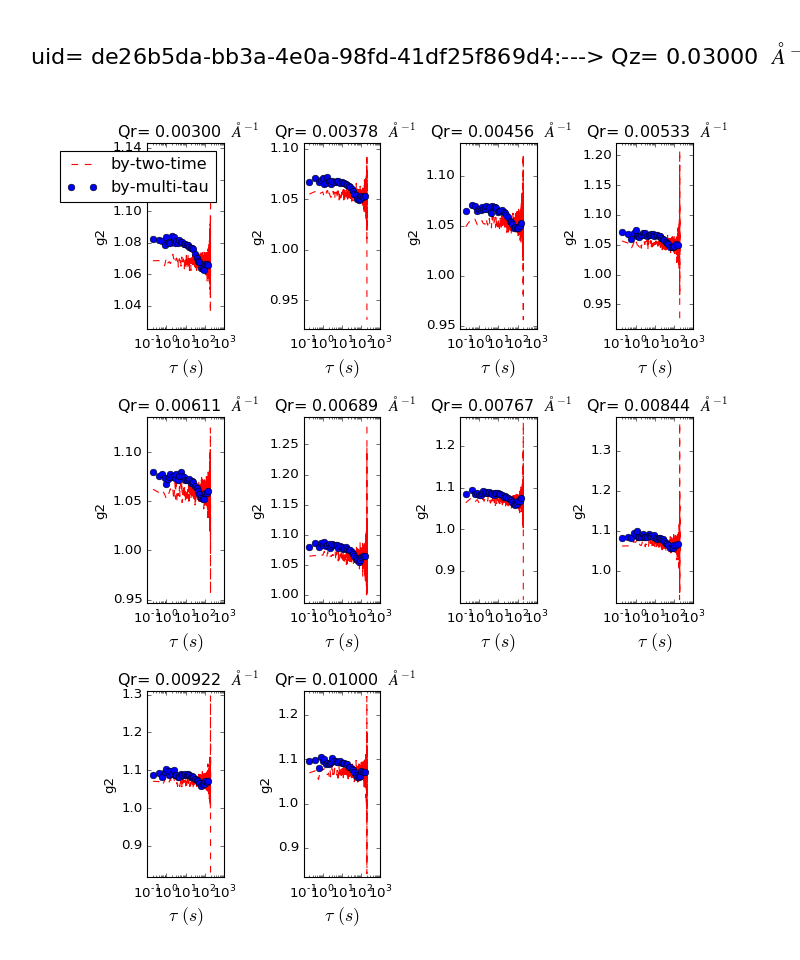

<IPython.core.display.Javascript object>


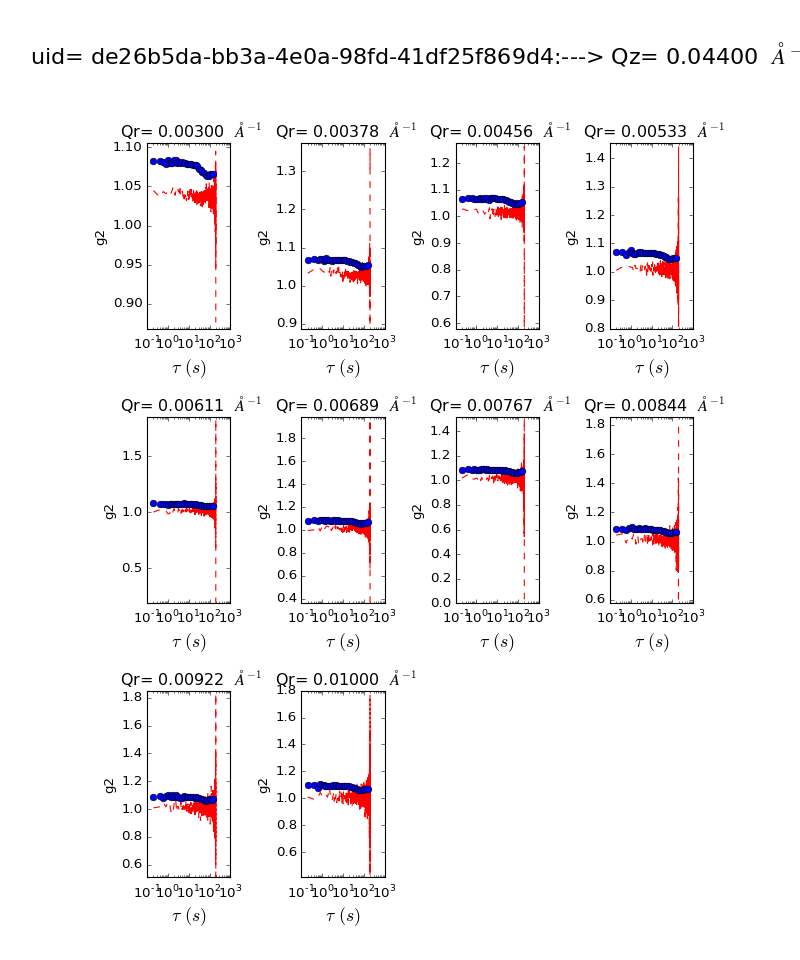

In [59]:
if run_two_time:
    plot_gisaxs_two_g2( g2, taus, 
                 g2b, np.arange( g2b.shape[0]) *timeperframe,
                 res_pargs=res_pargs, vlim=[.99, 1.01] )

# The End!